In [2]:
from typing import List, Dict, Any
from config import url_prefix
from utils import save_compressed_json, load_compressed_json
from utils.connection import MongoDBConnection
from scipy.io import loadmat
import scipy.sparse
import numpy
from sklearn.manifold import MDS
from matplotlib import pyplot as plt

In [2]:
item_count = 10
data = load_compressed_json("temp/classfied_static.json.gz")
for k, v in sorted(data.items(), key=lambda d: d[1]["COUNT"], reverse=True):
    count = v.pop("COUNT")
    units = sorted(v.items(), key=lambda d: d[1], reverse=True)
    print("TYPE={} COUNT={}".format(k,count))
    for i in range(item_count):
        print("%s --> %f%%" % (units[i][0], units[i][1] * 100.0 / count))
    print("\n")

TYPE=9 COUNT=68005
Men --> 100.000000%
HD Gays --> 6.783325%
Sexy --> 3.196824%
Crossdressers --> 2.280715%
Amateur --> 1.932211%
Black --> 1.698405%
Fucking --> 1.673406%
Sissy --> 1.626351%
Fun --> 1.608705%
Sex Toys --> 1.579296%


TYPE=19 COUNT=65372
Amateur --> 100.000000%
MILFs --> 7.162088%
Asian --> 6.250382%
French --> 5.875604%
Cumshots --> 4.815517%
Babes --> 4.137857%
Public Nudity --> 3.737074%
Couple --> 3.603989%
Hidden Cams --> 3.394420%
Black and Ebony --> 3.383712%


TYPE=14 COUNT=57644
Matures --> 8.176046%
German --> 5.936437%
Pornstars --> 5.872250%
Foot Fetish --> 5.403858%
Japanese --> 5.077718%
Black and Ebony --> 4.536465%
Hentai --> 4.526056%
Cumshots --> 4.487891%
Cartoons --> 4.342169%
Hidden Cams --> 4.104504%


TYPE=63 COUNT=34249
Vintage --> 99.997080%
Pornstars --> 24.219685%
Hairy --> 23.825513%
Classic --> 15.991708%
Group Sex --> 11.544863%
Hardcore --> 11.381354%
Retro --> 10.724401%
Cumshots --> 7.973955%
German --> 7.752051%
Lesbians --> 6.911151%


Brunettes --> 14.212559%
Hardcore --> 12.760242%
Blowjobs --> 9.922767%
Fucked --> 8.881800%
Webcams --> 8.394896%
Blondes --> 7.588986%
Hidden Cams --> 7.505037%
MILFs --> 7.093687%


TYPE=12 COUNT=11776
Amateur --> 100.000000%
Gay Porn --> 99.719769%
Blowjobs --> 31.818954%
Men --> 30.511209%
HD Gays --> 23.938519%
Twinks --> 23.437500%
Bareback --> 20.788043%
Big Cocks --> 18.571671%
Masturbation --> 11.540421%
Handjobs --> 8.797554%


TYPE=73 COUNT=11687
Tits --> 100.000000%
Blondes --> 27.047146%
Brunettes --> 14.443399%
Pornstars --> 14.109695%
Babes --> 12.415504%
Japanese --> 11.003679%
MILFs --> 10.515958%
Blowjobs --> 7.170360%
Softcore --> 7.161804%
Celebrities --> 6.819543%


TYPE=6 COUNT=11075
German --> 100.000000%
Amateur --> 99.981941%
HD Videos --> 41.191874%
Teens --> 13.589165%
Blondes --> 11.358916%
MILFs --> 9.345372%
Sexter Media Channel --> 8.902935%
Big Boobs --> 7.521445%
Cumshots --> 6.961625%
Matures --> 6.230248%


TYPE=78 COUNT=10955
Big Tits --> 99.990872%

In [3]:
url_keys = load_compressed_json("temp/urls_key_sparse.json.gz")
classfied = [int(i[0]) for i in loadmat("matlab/res127.mat")["res"]]

Class count=1727


In [7]:
def visualize_labels(url_set:List[str], N:int,title:str="Class="):
    with MongoDBConnection() as mongo_conn:
        coll = mongo_conn.get_database("spider").get_collection("xhamster_storage")
        labels_data  = [doc["label"] for doc in coll.find({"_id":{"$in":url_set}} , {"label": 1})]
    label_static = dict()
    for labels in labels_data:
        for label in labels:
            if label in label_static:
                label_static[label]+=1
            else:
                label_static[label]=1
    label_set = [x[0] for x in sorted(label_static.items(),key=lambda x:x[1],reverse=True)[1:N]]
    label_dict = {x:i for i,x in enumerate(label_set)}
    M = numpy.zeros(shape=(len(labels_data),len(label_set)))
    for index,labels in enumerate(labels_data):
        for label in labels:
            if label in label_dict:
                M[index][label_dict[label]] = 1.0
    M = numpy.matrix(M)
    NOT_M = 1-M
    DM = 1.0 - ((M.transpose()*M) / (len(labels_data) - NOT_M.transpose()*NOT_M))
    mds = MDS(dissimilarity="precomputed")
    mds.fit(DM)
    plt.figure(1)
    point_size = numpy.diag(OR_M)
    data = mds.embedding_.transpose()
    plt.scatter(data[0],data[1],s=point_size,c='red',linewidths=0,marker='o',alpha=0.5)
    for label in label_set:
        il = label_dict[label]
        plt.text(data[0][il],data[1][il],label)
    plt.title(title)
    plt.show()

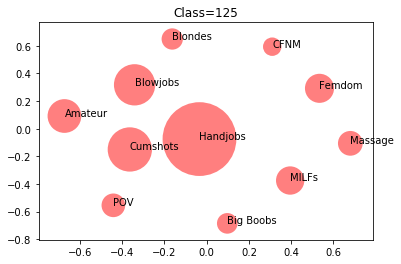

In [8]:
for i in (124,):
    visualize_labels([url_prefix + url_key for url_key, class_id in zip(url_keys, classfied) if class_id==(i+1)],12,"Class={}".format(i+1))

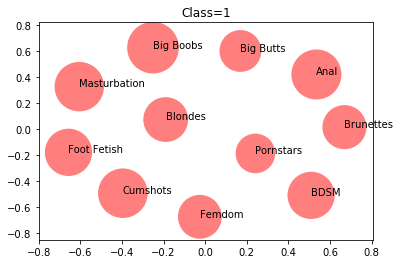

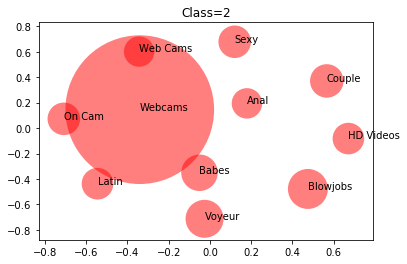

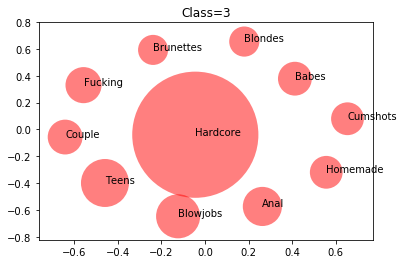

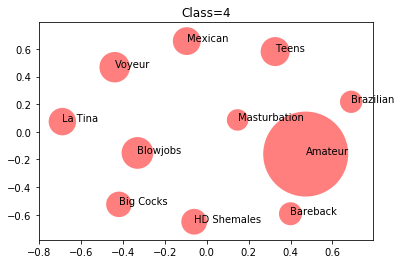

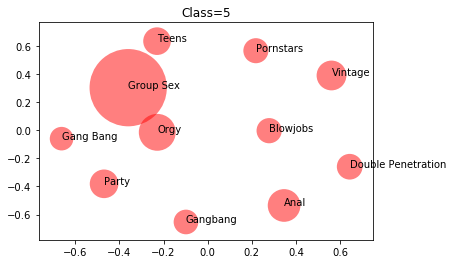

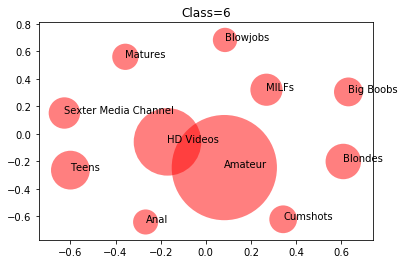

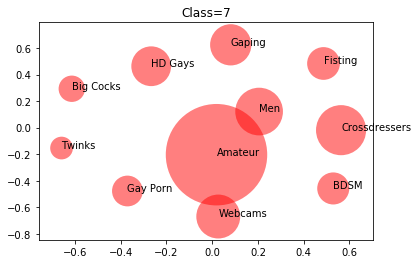

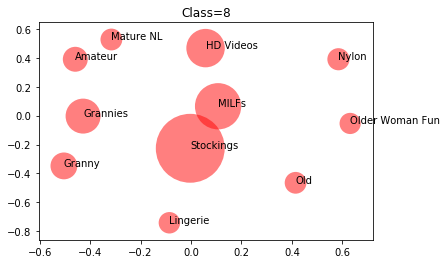

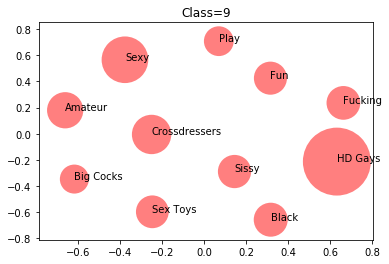

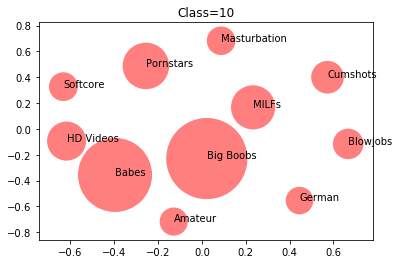

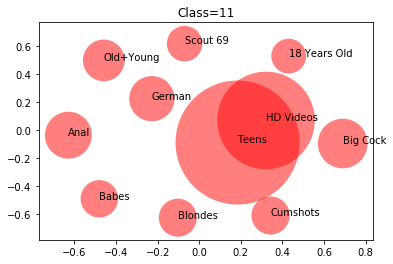

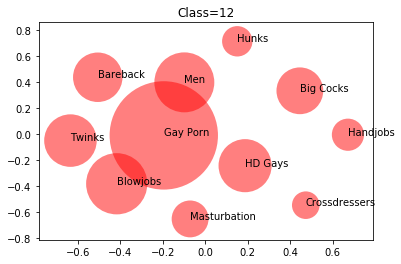

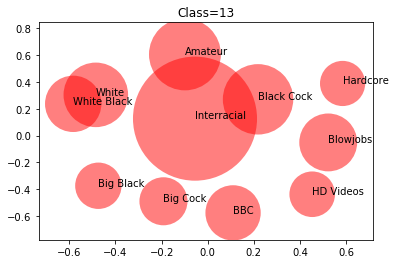

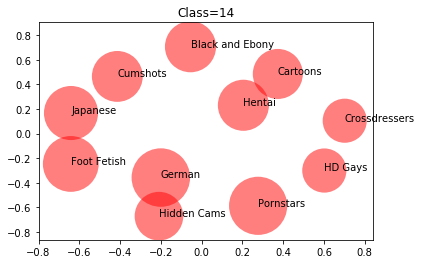

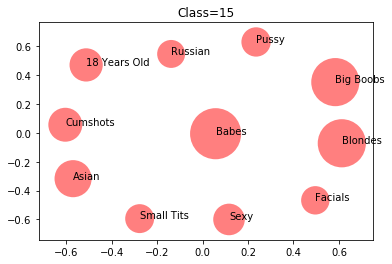

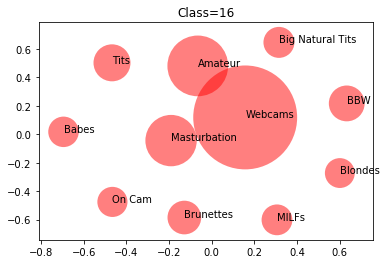

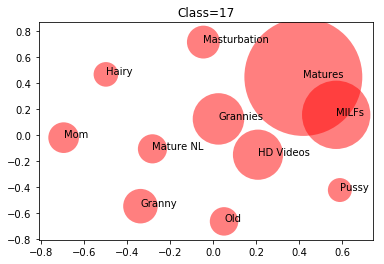

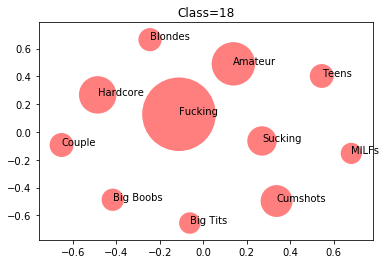

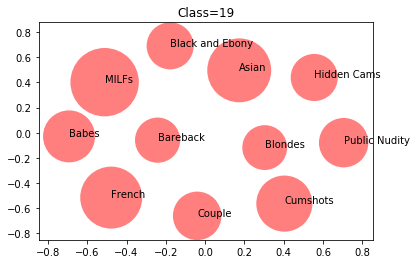

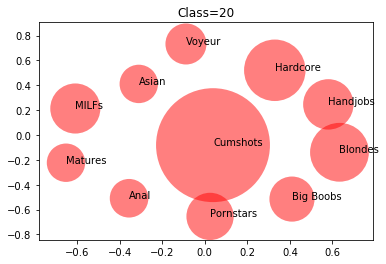

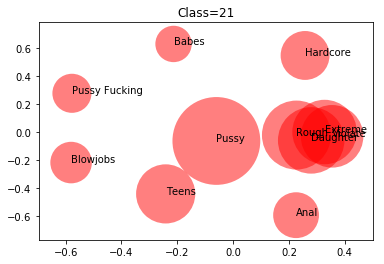

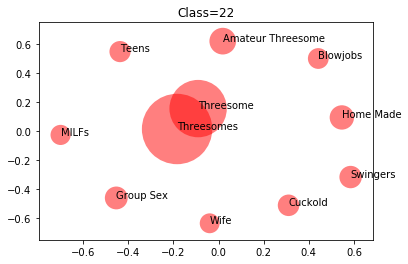

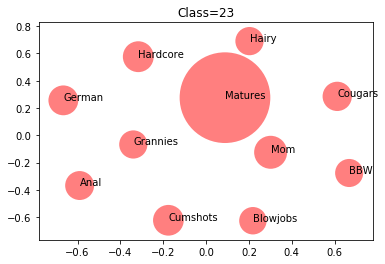

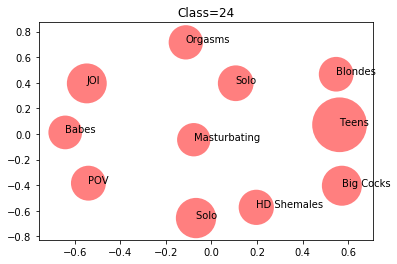

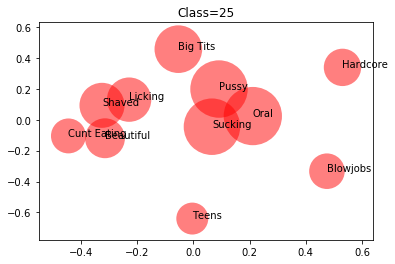

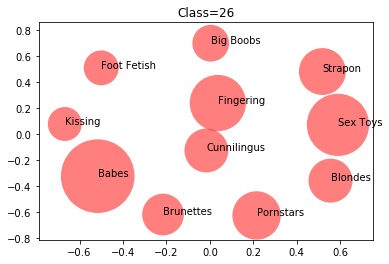

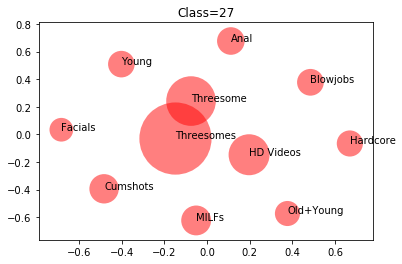

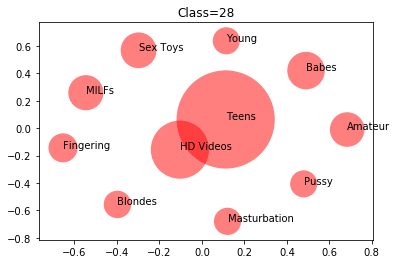

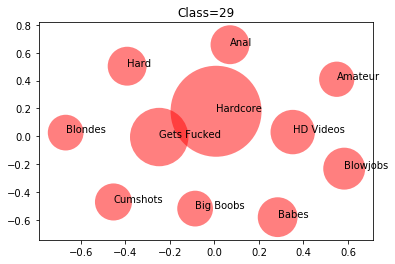

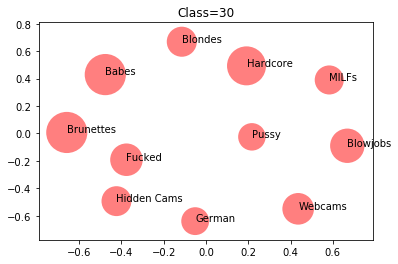

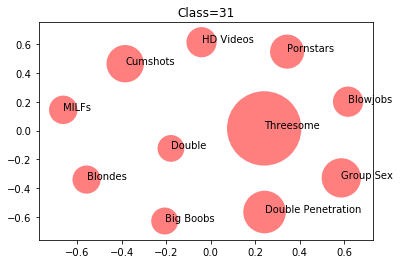

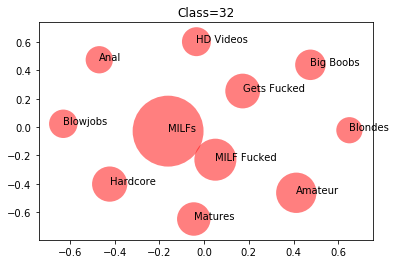

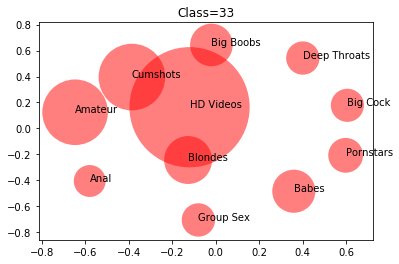

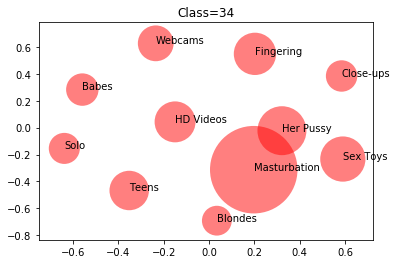

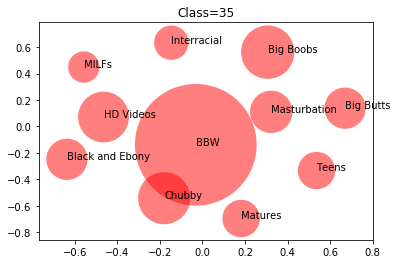

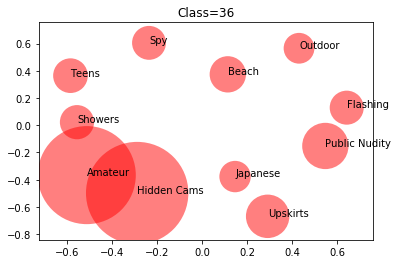

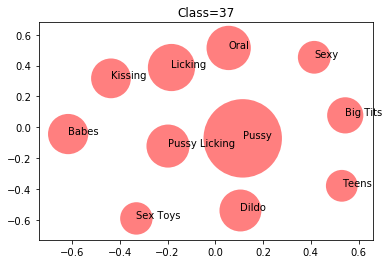

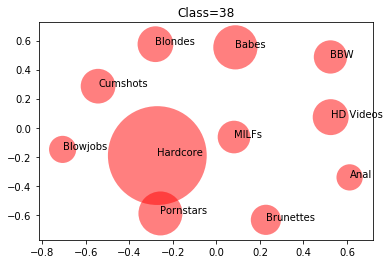

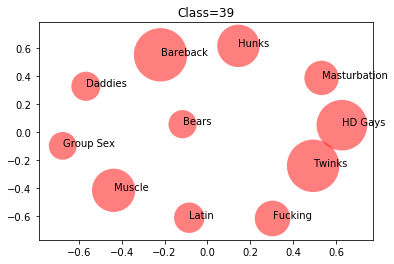

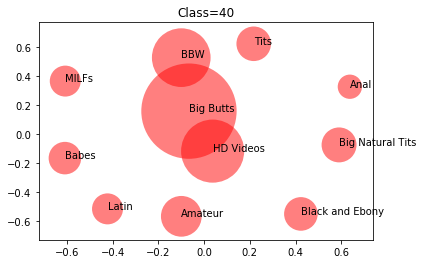

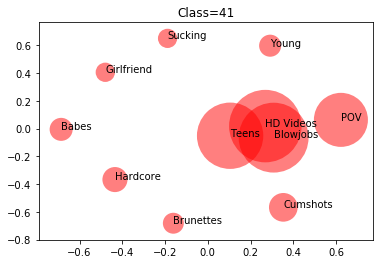

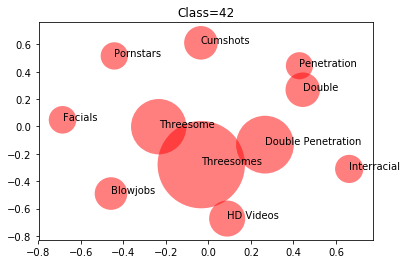

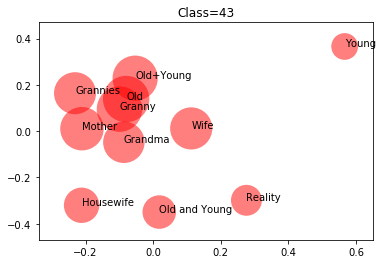

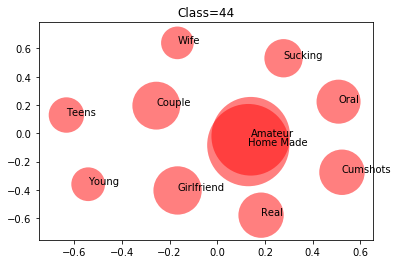

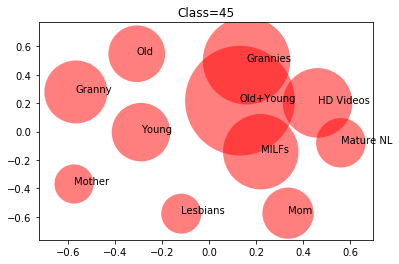

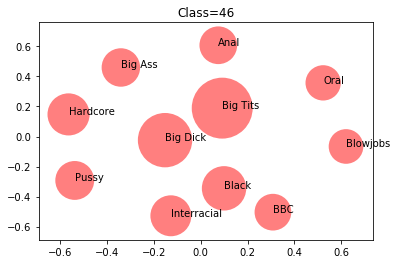

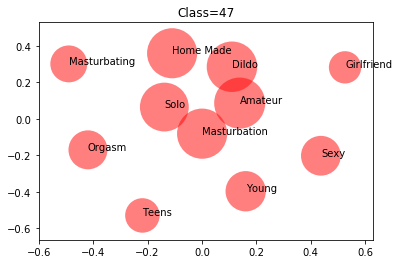

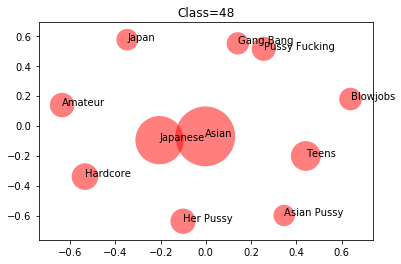

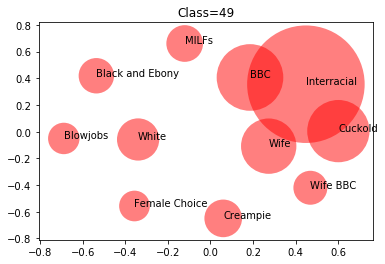

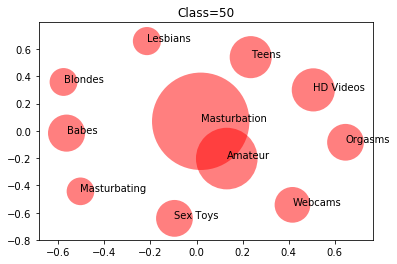

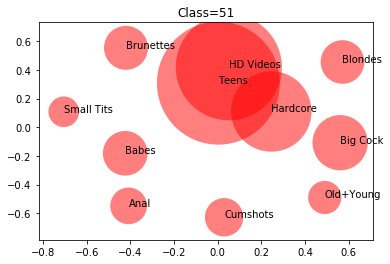

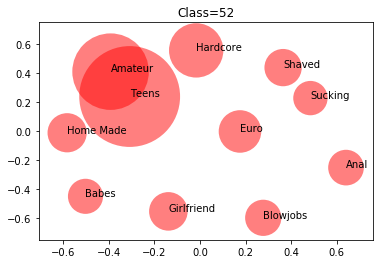

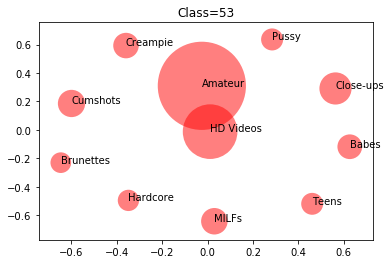

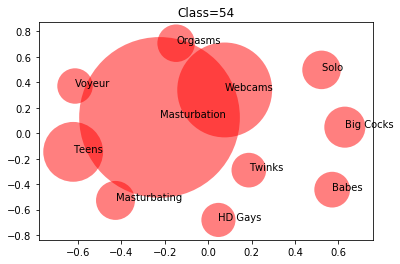

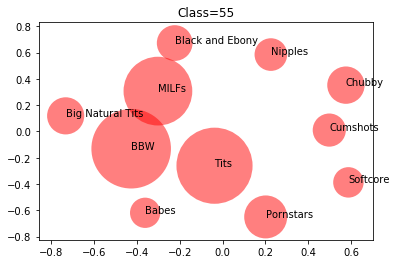

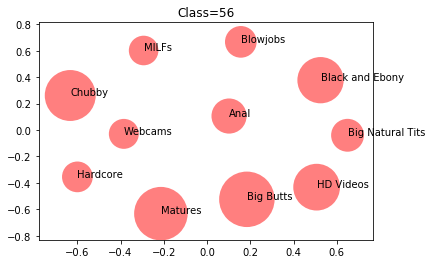

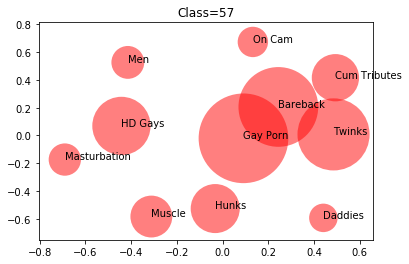

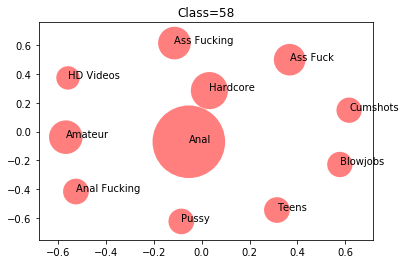

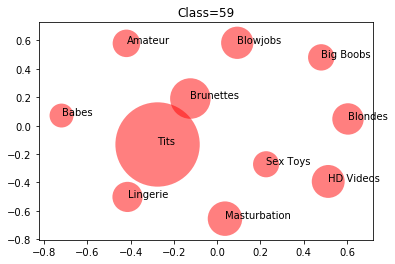

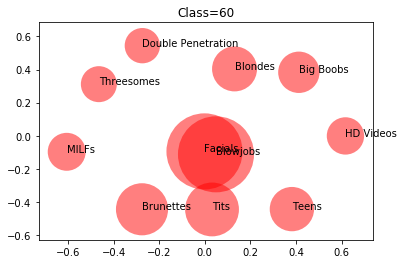

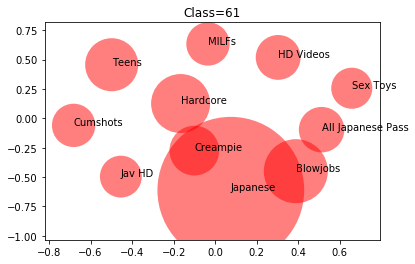

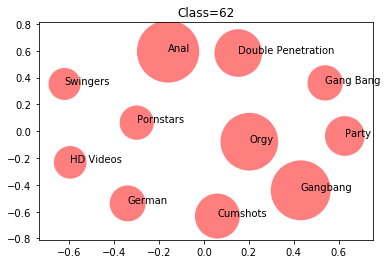

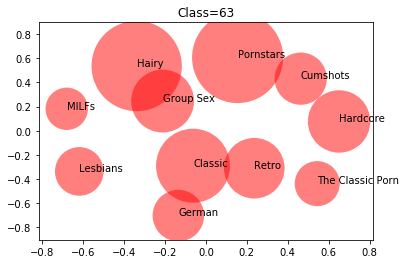

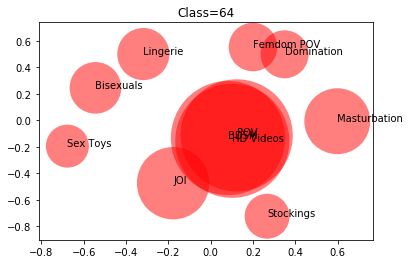

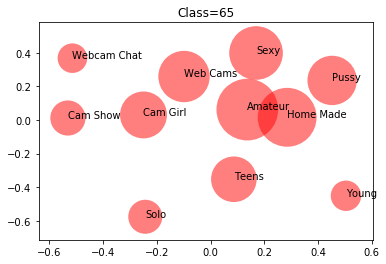

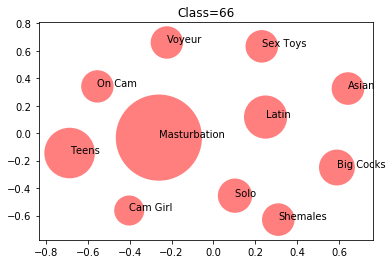

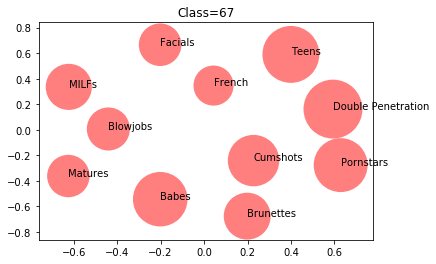

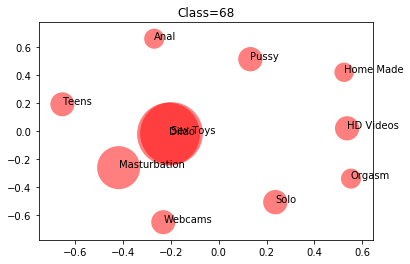

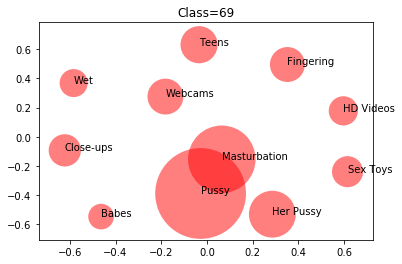

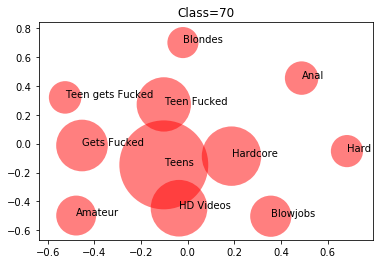

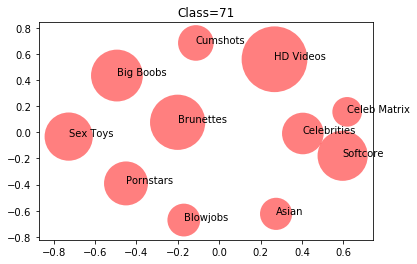

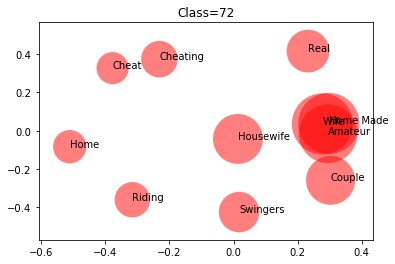

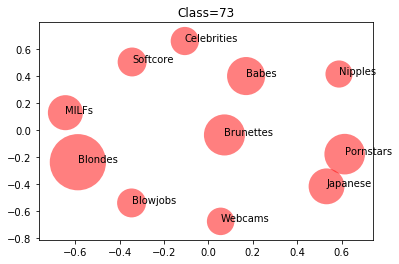

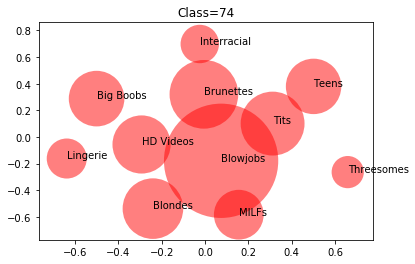

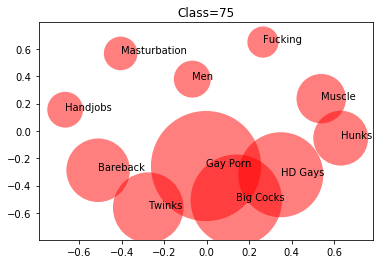

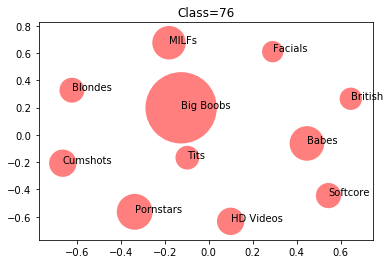

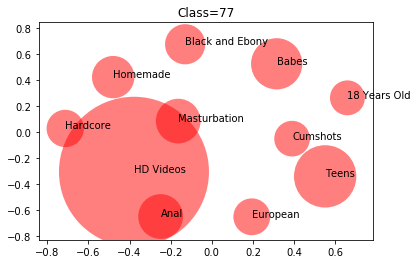

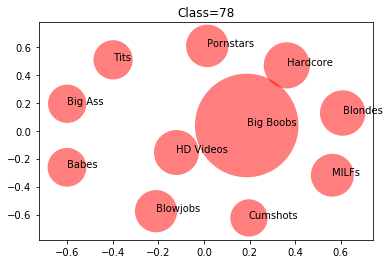

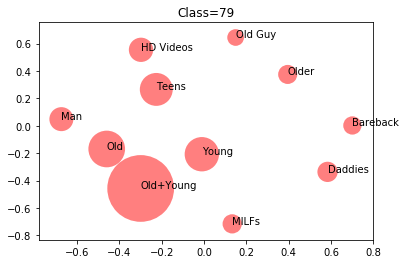

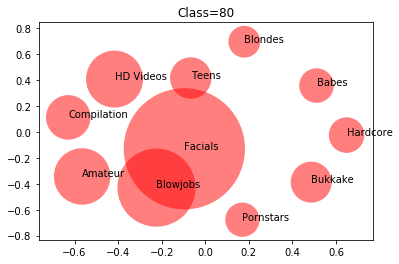

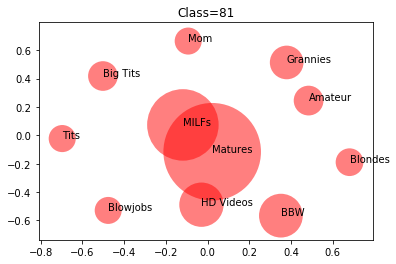

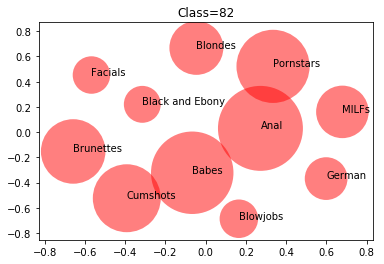

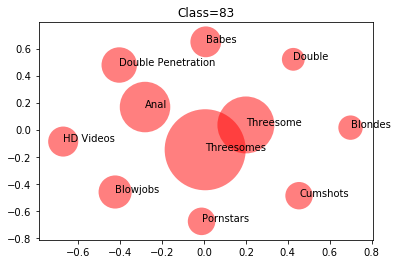

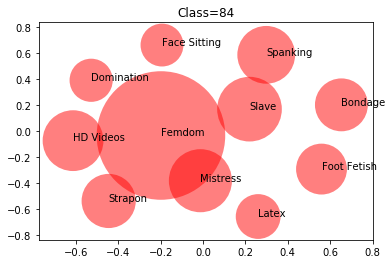

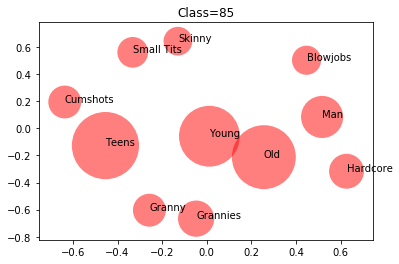

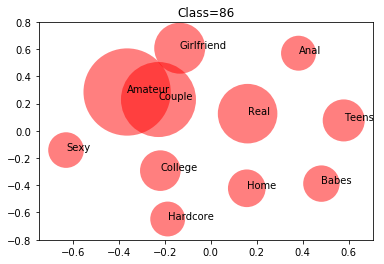

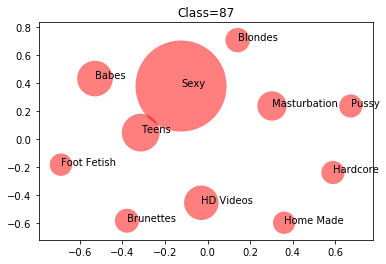

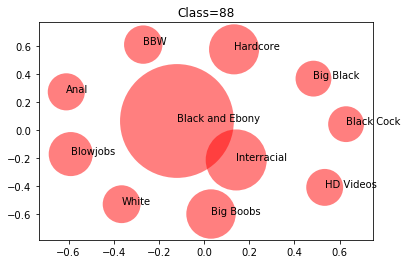

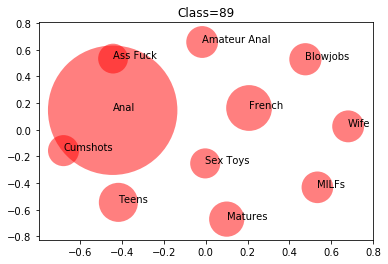

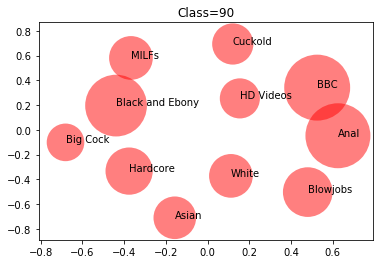

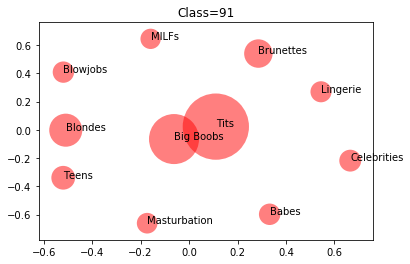

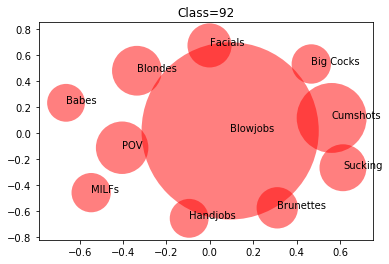

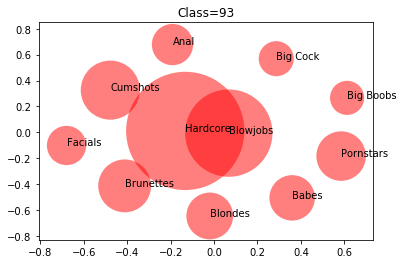

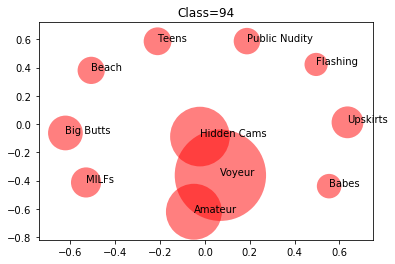

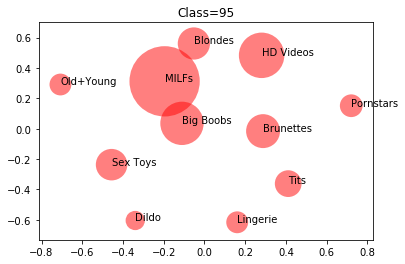

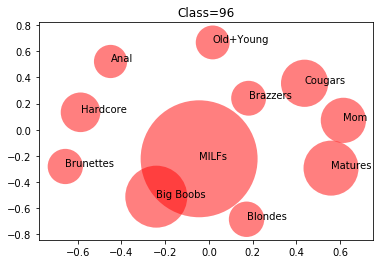

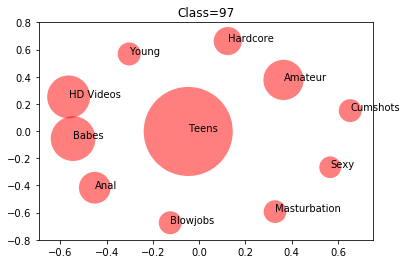

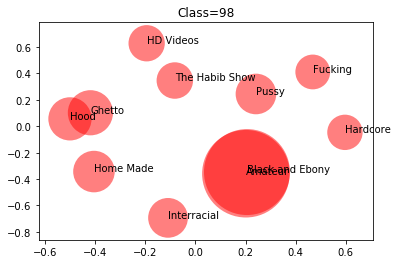

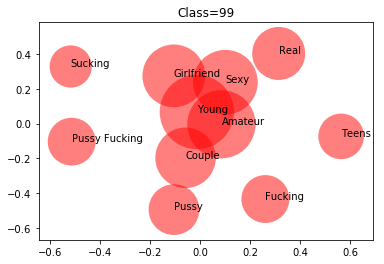

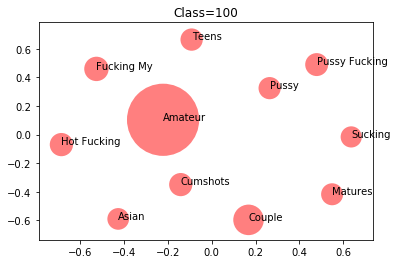

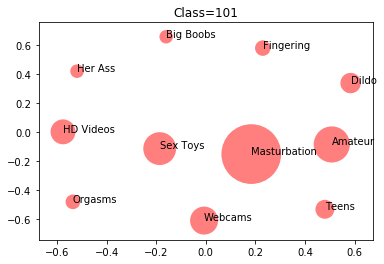

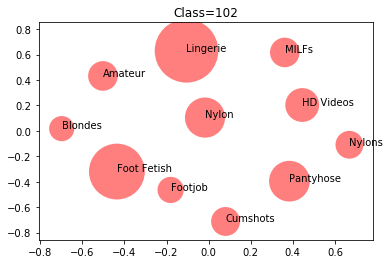

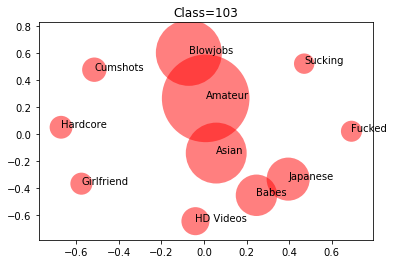

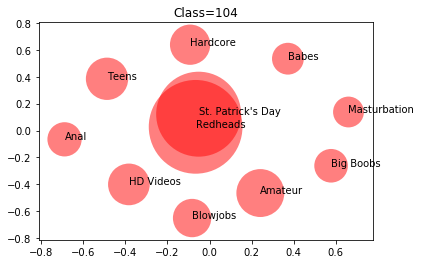

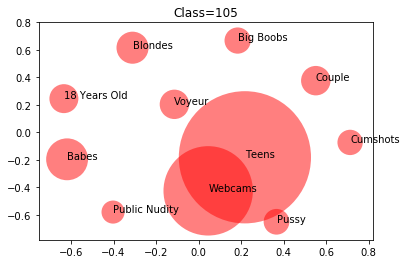

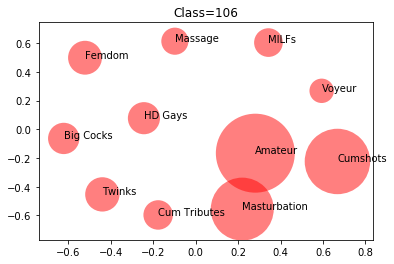

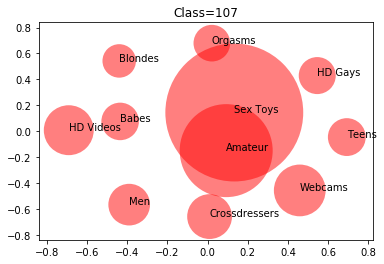

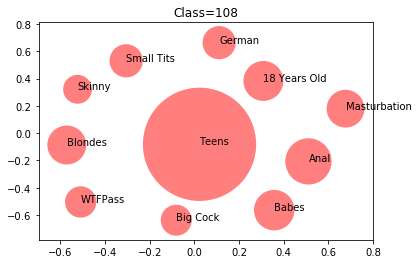

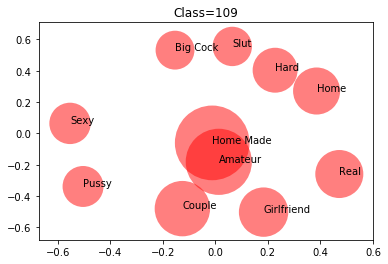

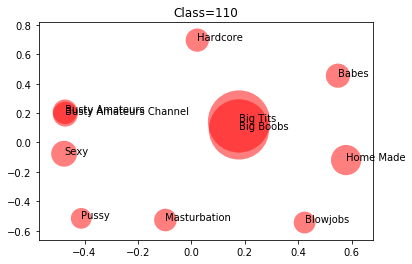

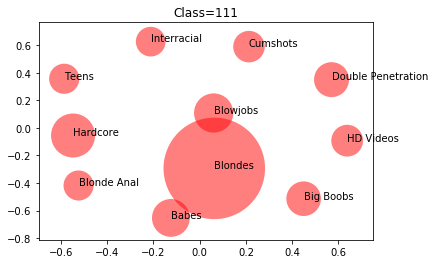

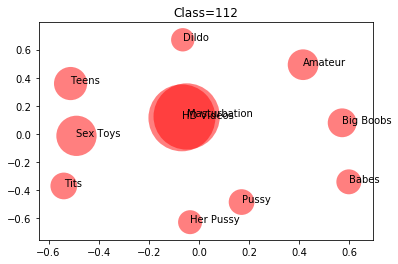

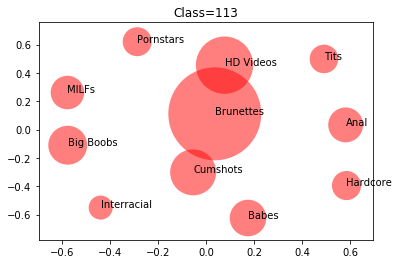

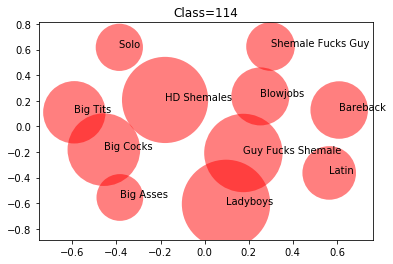

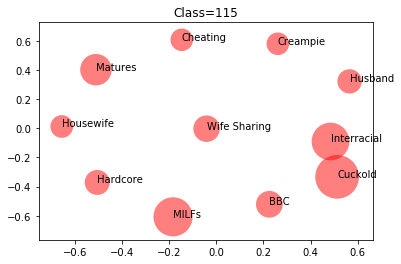

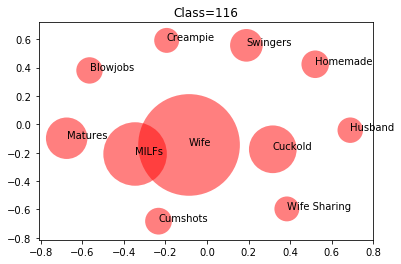

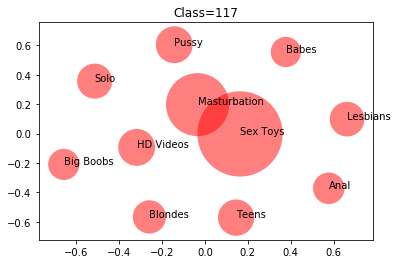

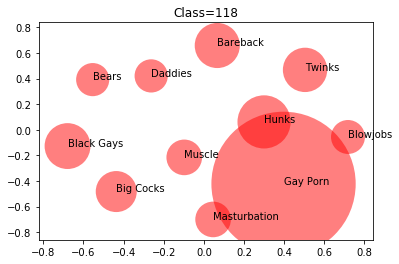

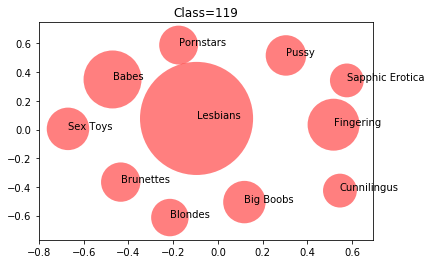

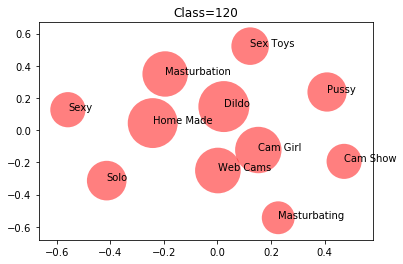

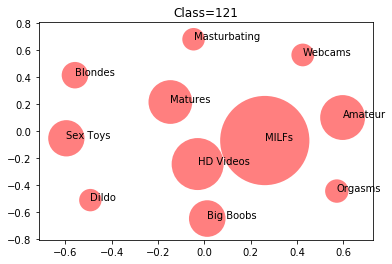

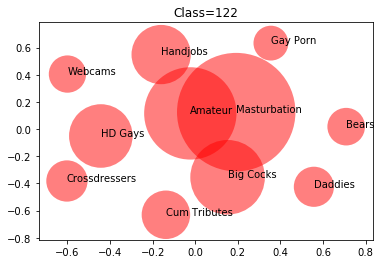

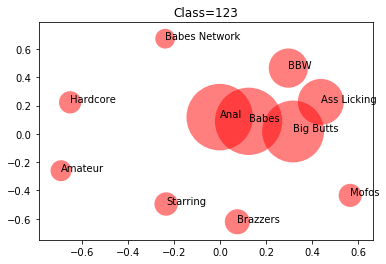

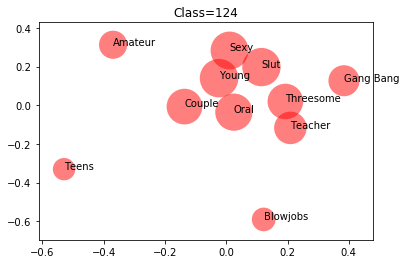

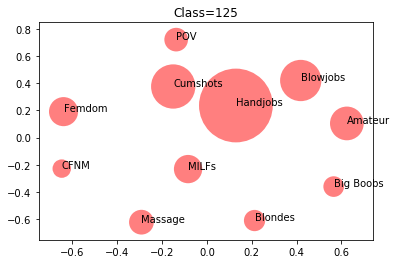

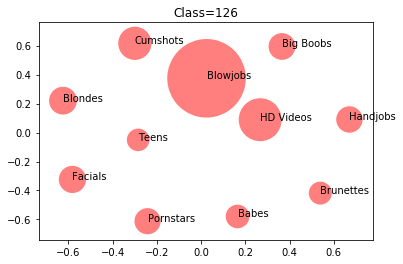

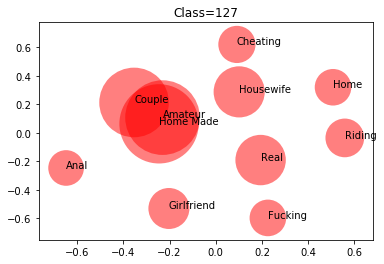

In [88]:
for i in range(127):
    visualize_labels([url_prefix + url_key for url_key, class_id in zip(url_keys, classfied) if class_id==(i+1)],12,"Class={}".format(i+1))

In [ ]:
from sklearn.cluster import DBSCAN
X = loadmat("matlab/dr_data.mat")['ru']
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("{} classes clusted.".format(n_clusters_))